# Equilibration tests

In [1]:
import numpy as np
import copy as copy
from scipy.linalg import toeplitz, block_diag
import matplotlib.pyplot as plt
import time
from scipy import sparse
from scipy.sparse import block_diag, issparse, csr_matrix, diags
from scipy.stats.mstats import gmean

from a2dr.precondition import *

In [2]:
def prox_norm1(alpha = 1.0):
    return lambda v, t: (v - t*alpha).maximum(0) - (-v - t*alpha).maximum(0) if sparse.issparse(v) else \
                        np.maximum(v - t*alpha,0) - np.maximum(-v - t*alpha,0)

## Example 1: random

In [3]:
np.random.seed(1)

## version 1: random
m = 200
N = 5
density = 0.001
max_size = 20 # maximum size of each block
n_list = [np.random.randint(max_size+1) for i in range(N)] # list of variable block sizes n_i
n = np.sum(n_list) # total variable dimension = n_1 + ... + n_N
A_list = [sparse.random(m, n_list[i], density=density, data_rvs=np.random.randn) for i in range(N)]
b = np.random.randn(m)
prox_list = [prox_norm1] * N
A = csr_matrix(sparse.hstack(A_list))

In [4]:
p_eq_list, A_eq_list, db, e = precondition(prox_list, A_list, b)
A_eq = csr_matrix(sparse.hstack(A_eq_list))

In [5]:
print('[Sanity Check]')
print('\|A\|_2 = {}, \|DAE\|_2 = {}'.format(sparse.linalg.norm(A), sparse.linalg.norm(A_eq)))
print('min(|A|) = {}, max(|A|) = {}, mean(|A|) = {}'.format(np.min(np.abs(A)), 
                                                            np.max(np.abs(A)), sparse.csr_matrix.mean(np.abs(A))))
print('min(|DAE|) = {}, max(|DAE|) = {}, mean(|DAE|) = {}'.format(np.min(np.abs(A_eq)), 
                                                            np.max(np.abs(A_eq)), sparse.csr_matrix.mean(np.abs(A_eq))))

[Sanity Check]
\|A\|_2 = 2.9689197476981586, \|DAE\|_2 = 2.2360679774997902
min(|A|) = 0.0, max(|A|) = 1.6348441513221794, mean(|A|) = 0.0008255005952127677
min(|DAE|) = 0.0, max(|DAE|) = 0.8451542547285984, mean(|DAE|) = 0.0006573421981221797


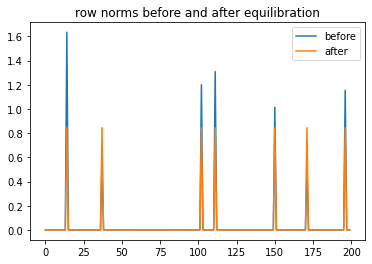

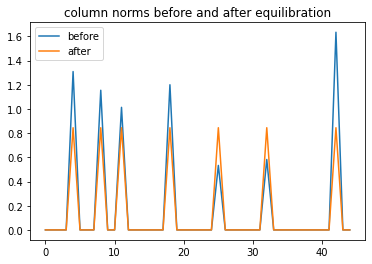

In [6]:
# row norms
A_norms_r = np.sqrt((A.power(2)).dot(np.ones(n))) 
A_eq_norms_r = np.sqrt((A_eq.power(2)).dot(np.ones(n))) 

# column norms
A_norms_c = np.sqrt(csr_matrix(A.power(2).T).dot(np.ones(m)))
A_eq_norms_c = np.sqrt(csr_matrix(A_eq.power(2).T).dot(np.ones(m)))

# visualization of row norms
plt.plot(A_norms_r)
plt.plot(A_eq_norms_r)
plt.title('row norms before and after equilibration')
plt.legend(['before', 'after'])
plt.show()

# visualization of column norms
plt.plot(A_norms_c)
plt.plot(A_eq_norms_c)
plt.title('column norms before and after equilibration')
plt.legend(['before', 'after'])
plt.show()

## Example 2: consensus

In [7]:
np.random.seed(1)

## version 2: consensus
N = 2
ni = 20
m = ni * (N-1)
n = ni * N
A_list = [sparse.eye(ni), -sparse.eye(ni)]
b = np.random.randn(m)
prox_list = [prox_norm1] * N
A = csr_matrix(sparse.hstack(A_list))

In [8]:
p_eq_list, A_eq_list, db, e = precondition(prox_list, A_list, b)
A_eq = csr_matrix(sparse.hstack(A_eq_list))

In [9]:
print('[Sanity Check]')
print('\|A\|_2 = {}, \|DAE\|_2 = {}'.format(sparse.linalg.norm(A), sparse.linalg.norm(A_eq)))
print('min(|A|) = {}, max(|A|) = {}, mean(|A|) = {}'.format(np.min(np.abs(A)), 
                                                            np.max(np.abs(A)), sparse.csr_matrix.mean(np.abs(A))))
print('min(|DAE|) = {}, max(|DAE|) = {}, mean(|DAE|) = {}'.format(np.min(np.abs(A_eq)), 
                                                            np.max(np.abs(A_eq)), sparse.csr_matrix.mean(np.abs(A_eq))))

[Sanity Check]
\|A\|_2 = 6.324555320336759, \|DAE\|_2 = 1.4142135623730951
min(|A|) = 0.0, max(|A|) = 1.0, mean(|A|) = 0.05000000000000001
min(|DAE|) = 0.0, max(|DAE|) = 0.22360679774997896, mean(|DAE|) = 0.01118033988749895


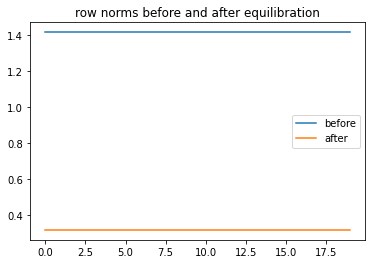

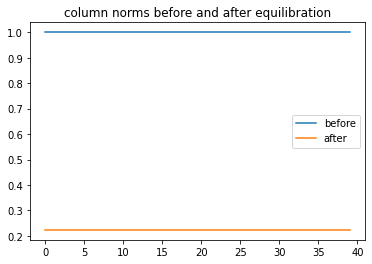

In [10]:
# row norms
A_norms_r = np.sqrt((A.power(2)).dot(np.ones(n))) 
A_eq_norms_r = np.sqrt((A_eq.power(2)).dot(np.ones(n))) 

# column norms
A_norms_c = np.sqrt(csr_matrix(A.power(2).T).dot(np.ones(m)))
A_eq_norms_c = np.sqrt(csr_matrix(A_eq.power(2).T).dot(np.ones(m)))

# visualization of row norms
plt.plot(A_norms_r)
plt.plot(A_eq_norms_r)
plt.title('row norms before and after equilibration')
plt.legend(['before', 'after'])
plt.show()

# visualization of column norms
plt.plot(A_norms_c)
plt.plot(A_eq_norms_c)
plt.title('column norms before and after equilibration')
plt.legend(['before', 'after'])
plt.show()

## Example 3: l1 trend filtering

In [11]:
np.random.seed(1)

## version 3: l1_trend_filtering
def prox_norm1(alpha = 1.0):
    return lambda v, t: (v - t*alpha).maximum(0) - (-v - t*alpha).maximum(0) if sparse.issparse(v) else \
                        np.maximum(v - t*alpha,0) - np.maximum(-v - t*alpha,0)

# Problem data.
N = 2
n0 = 2*10**4
n = 2*n0-2
m = n0-2
y = np.random.randn(n)
alpha = 0.1*np.linalg.norm(y, np.inf)

# Form second difference matrix.
D = sparse.lil_matrix(sparse.eye(n0))
D.setdiag(-2, k = 1)
D.setdiag(1, k = 2)
D = D[:(n0-2),:]

# Convert problem to standard form.
# f_1(x_1) = (1/2)||y - x_1||_2^2, f_2(x_2) = \alpha*||x_2||_1.
# A_1 = D, A_2 = -I_{n-2}, b = 0.
prox_list = [lambda v, t: (t*y + v)/(t + 1.0), prox_norm1(alpha)]
A_list = [D, -sparse.eye(n0-2)]
b = np.zeros(n0-2)

b = np.random.randn(m)
prox_list = [prox_norm1] * N
A = csr_matrix(sparse.hstack(A_list))

In [12]:
p_eq_list, A_eq_list, db, e = precondition(prox_list, A_list, b)
A_eq = csr_matrix(sparse.hstack(A_eq_list))

In [13]:
print('[Sanity Check]')
print('\|A\|_2 = {}, \|DAE\|_2 = {}'.format(sparse.linalg.norm(A), sparse.linalg.norm(A_eq)))
print('min(|A|) = {}, max(|A|) = {}, mean(|A|) = {}'.format(np.min(np.abs(A)), 
                                                            np.max(np.abs(A)), sparse.csr_matrix.mean(np.abs(A))))
print('min(|DAE|) = {}, max(|DAE|) = {}, mean(|DAE|) = {}'.format(np.min(np.abs(A_eq)), 
                                                            np.max(np.abs(A_eq)), sparse.csr_matrix.mean(np.abs(A_eq))))

[Sanity Check]
\|A\|_2 = 374.1470299227297, \|DAE\|_2 = 1.4142135623730947
min(|A|) = 0.0, max(|A|) = 2.0, mean(|A|) = 0.00012500625031251558
min(|DAE|) = 0.0, max(|DAE|) = 0.007071421353354317, mean(|DAE|) = 4.654983797555194e-07


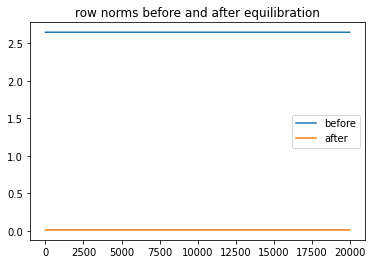

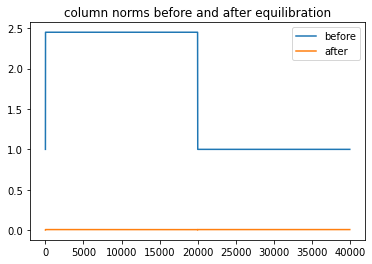

In [14]:
# row norms
A_norms_r = np.sqrt((A.power(2)).dot(np.ones(n))) 
A_eq_norms_r = np.sqrt((A_eq.power(2)).dot(np.ones(n))) 

# column norms
A_norms_c = np.sqrt(csr_matrix(A.power(2).T).dot(np.ones(m)))
A_eq_norms_c = np.sqrt(csr_matrix(A_eq.power(2).T).dot(np.ones(m)))

# visualization of row norms
plt.plot(A_norms_r)
plt.plot(A_eq_norms_r)
plt.title('row norms before and after equilibration')
plt.legend(['before', 'after'])
plt.show()

# visualization of column norms
plt.plot(A_norms_c)
plt.plot(A_eq_norms_c)
plt.title('column norms before and after equilibration')
plt.legend(['before', 'after'])
plt.show()